In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])


In [3]:
train_dataset = datasets.ImageFolder(root='train_sample', transform=transform)
val_dataset = datasets.ImageFolder(root='val_sample', transform=transform)
test_dataset = datasets.ImageFolder(root='test_sample', transform=transform)


In [4]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(images, labels, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

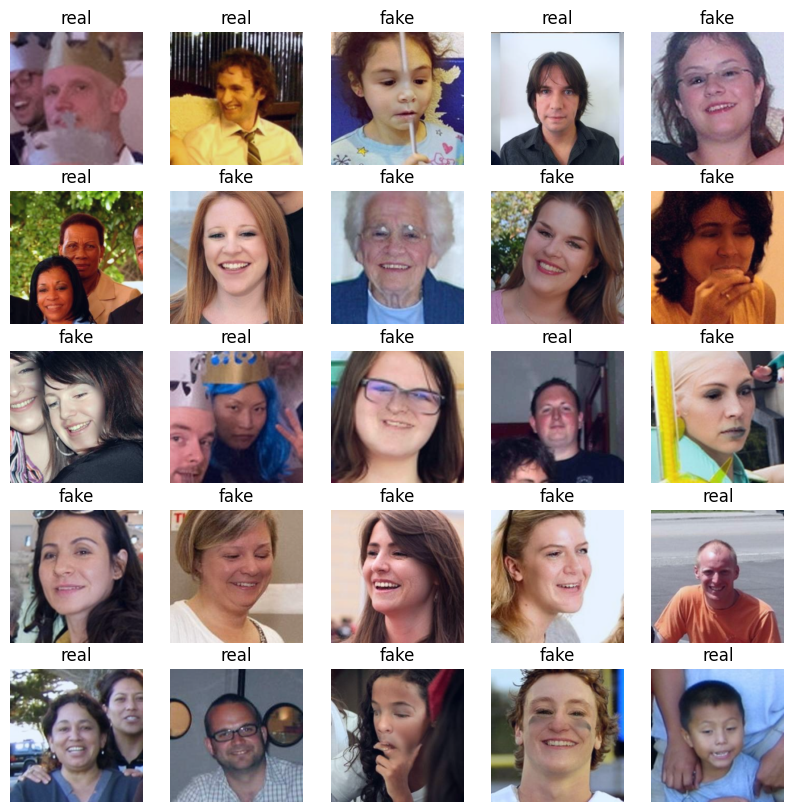

In [9]:
images, labels = next(iter(train_loader))
class_names = train_dataset.classes
show_images(images, labels, class_names)

In [12]:
import torchvision.models as models
import torch.nn as nn
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: real vs fake

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [14]:
criterion = nn.CrossEntropyLoss()


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [16]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%')


Epoch [1/10], Loss: 0.36967699946119237, Accuracy: 86.25%
Epoch [2/10], Loss: 0.13415586260648873, Accuracy: 94.5%
Epoch [3/10], Loss: 0.0452934645044689, Accuracy: 97.75%
Epoch [4/10], Loss: 0.027612592147376675, Accuracy: 99.25%
Epoch [5/10], Loss: 0.011165495010433145, Accuracy: 99.75%
Epoch [6/10], Loss: 0.013862426258408679, Accuracy: 99.5%
Epoch [7/10], Loss: 0.011174711530866962, Accuracy: 99.75%
Epoch [8/10], Loss: 0.021339431387157395, Accuracy: 99.5%
Epoch [9/10], Loss: 0.016718387361974098, Accuracy: 99.0%
Epoch [10/10], Loss: 0.012215889403775621, Accuracy: 99.75%


In [17]:
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100*correct/total}%')


Validation Loss: 1.7745428383350372, Validation Accuracy: 65.66666666666667%


In [18]:
torch.save(model.state_dict(), 'deepfake_model.pth')


C:\Users\prith\AppData\Local\Temp\ipykernel_41528\3474601125.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deepfake_model.pth'))


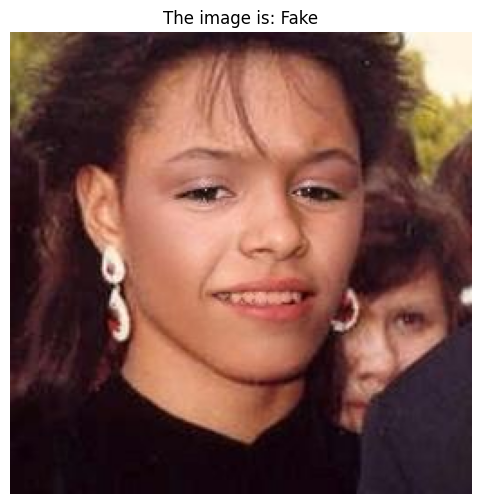

In [25]:
import torch
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification: real vs fake
model.load_state_dict(torch.load('deepfake_model.pth'))
model = model.to(device)
model.eval()

# Define the function to make predictions and display the image
def predict_and_show_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    # Map the prediction to class names
    class_names = ['Fake', 'Real']  # Assuming '0' is 'Fake' and '1' is 'Real'
    predicted_class = class_names[predicted.item()]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(np.array(image))
    plt.title(f'The image is: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = 'val_sample/fake/fake_988.jpg'
predict_and_show_image(image_path)
